In [9]:
import numpy as np
import matplotlib.pyplot as plt
import utils
from sklearn.decomposition import PCA
from gridworld3 import SimpleGrid

%matplotlib inline

cmap = plt.cm.viridis
cmap.set_bad(color='white')

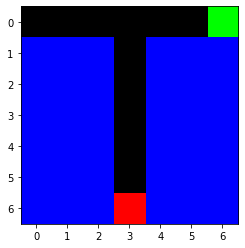

In [10]:
grid_size = 7
pattern="T_rooms"
env = SimpleGrid(grid_size, block_pattern=pattern, obs_mode="index")
env.reset(agent_pos=[grid_size-1,(grid_size//2)], goal_pos=[0, grid_size-1])
print(env)
#env.blocks.append([0,0])
plt.imshow(env.grid)

In [11]:
class TabularSuccessorAgent(object):
    def __init__(self, state_size, action_size, learning_rate, gamma):
        self.state_size = state_size
        self.action_size = action_size
        self.M = np.stack([np.identity(state_size) for i in range(action_size)])
        self.w = np.zeros([state_size])
        self.learning_rate = learning_rate
        self.gamma = gamma
        
    def Q_estimates(self, state, goal=None):
        # Generate Q values for all actions.
        if goal == None:
            goal = self.w
        else:
            goal = utils.onehot(goal, self.state_size)
        return np.matmul(self.M[:,state,:],goal)
    
    def sample_action(self, state, goal=None, epsilon=0.0):
        # Samples action using epsilon-greedy approach
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(self.action_size)
        else:
            Qs = self.Q_estimates(state, goal)
            action = np.argmax(Qs)
        return action
    
    def update_w(self, current_exp):
        # A simple update rule (for reward learning?)
        s_1 = current_exp[2]
        r = current_exp[3]
        error = r - self.w[s_1]
        self.w[s_1] += self.learning_rate * error        
        return error
    
    def update_sr(self, current_exp, next_exp):
        # SARSA TD learning rule
        s = current_exp[0]
        s_a = current_exp[1]
        s_1 = current_exp[2]
        s_a_1 = next_exp[1]
        r = current_exp[3]
        d = current_exp[4]
        I = utils.onehot(s, env.state_size)
        if d:            
            td_error = (I + self.gamma * utils.onehot(s_1, env.state_size) - self.M[s_a, s, :])
        else:
            td_error = (I + self.gamma * self.M[s_a_1, s_1, :] - self.M[s_a, s, :])
        self.M[s_a, s, :] += self.learning_rate * td_error
        
        return td_error

Episode 950/2000, TD Error: 0.061908821007618464, Test Lengths: 8.88
Switched reward locations
Episode 1950/2000, TD Error: 0.06664745283042792, Test Lengths: 49.00

Text(0.5, 1.0, 'Episode Lengths')

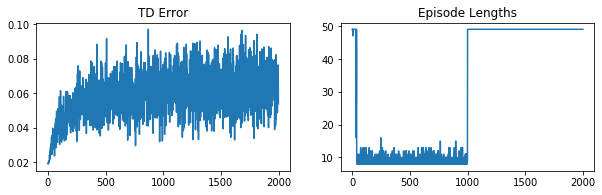

In [18]:
train_episode_length = 50
test_episode_length = 50
episodes = 2000
gamma = 0.95
lr = 5e-2
train_epsilon = 1.0
test_epsilon = 0.1

agent = TabularSuccessorAgent(env.state_size, env.action_size, lr, gamma)

experiences = []
test_experiences = []
test_lengths = []
lifetime_td_errors = []

for i in range(episodes):
    # Train phase
    agent_start = [grid_size-1,(grid_size//2)]
    if i < episodes // 2: #Integer division
        goal_pos = [0, grid_size-1]
    else:
        if i == episodes // 2:
            print("\nSwitched reward locations")
        goal_pos = [grid_size-1,grid_size-1]
    env.reset(agent_pos=agent_start, goal_pos=goal_pos)
    state = env.observation
    episodic_error = []
    for j in range(train_episode_length):
        action = agent.sample_action(state, epsilon=train_epsilon)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])
        state = state_next
        if (j > 1):
            td_sr = agent.update_sr(experiences[-2], experiences[-1])
            td_w = agent.update_w(experiences[-1])
            episodic_error.append(np.mean(np.abs(td_sr)))
        if env.done:
            td_sr = agent.update_sr(experiences[-1], experiences[-1])
            episodic_error.append(np.mean(np.abs(td_sr)))
            break
    lifetime_td_errors.append(np.mean(episodic_error))
    
    # Test phase
    env.reset(agent_pos=agent_start, goal_pos=goal_pos)
    state = env.observation
    for j in range(test_episode_length):
        action = agent.sample_action(state, epsilon=test_epsilon)
        reward = env.step(action)
        state_next = env.observation
        test_experiences.append([state, action, state_next, reward])
        state = state_next
        if env.done:
            break
    test_lengths.append(j)
    
    if i % 50 == 0:
        print('\rEpisode {}/{}, TD Error: {}, Test Lengths: {}'
              .format(i, episodes, np.mean(lifetime_td_errors[-50:]), 
                      np.mean(test_lengths[-50:])), end='')

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lifetime_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(test_lengths)
ax.set_title("Episode Lengths")

In [19]:
def print_occupancy(experiences, grid_size):
    occupancy_grid = np.zeros([grid_size, grid_size])
    for experience in experiences:
        occupancy_grid += env.state_to_grid(experience[0])
    occupancy_grid = np.sqrt(occupancy_grid)
    occupancy_grid = utils.mask_grid(occupancy_grid, env.blocks)
    plt.imshow(occupancy_grid)

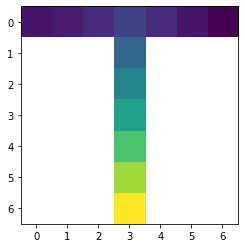

In [20]:
print_occupancy(experiences, grid_size)

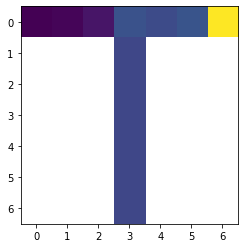

In [21]:
print_occupancy(test_experiences, grid_size)

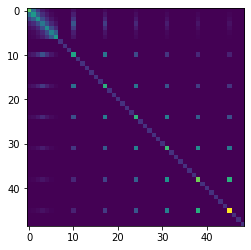

In [22]:
averaged_M = np.mean(agent.M, axis=0)
plt.imshow(averaged_M)

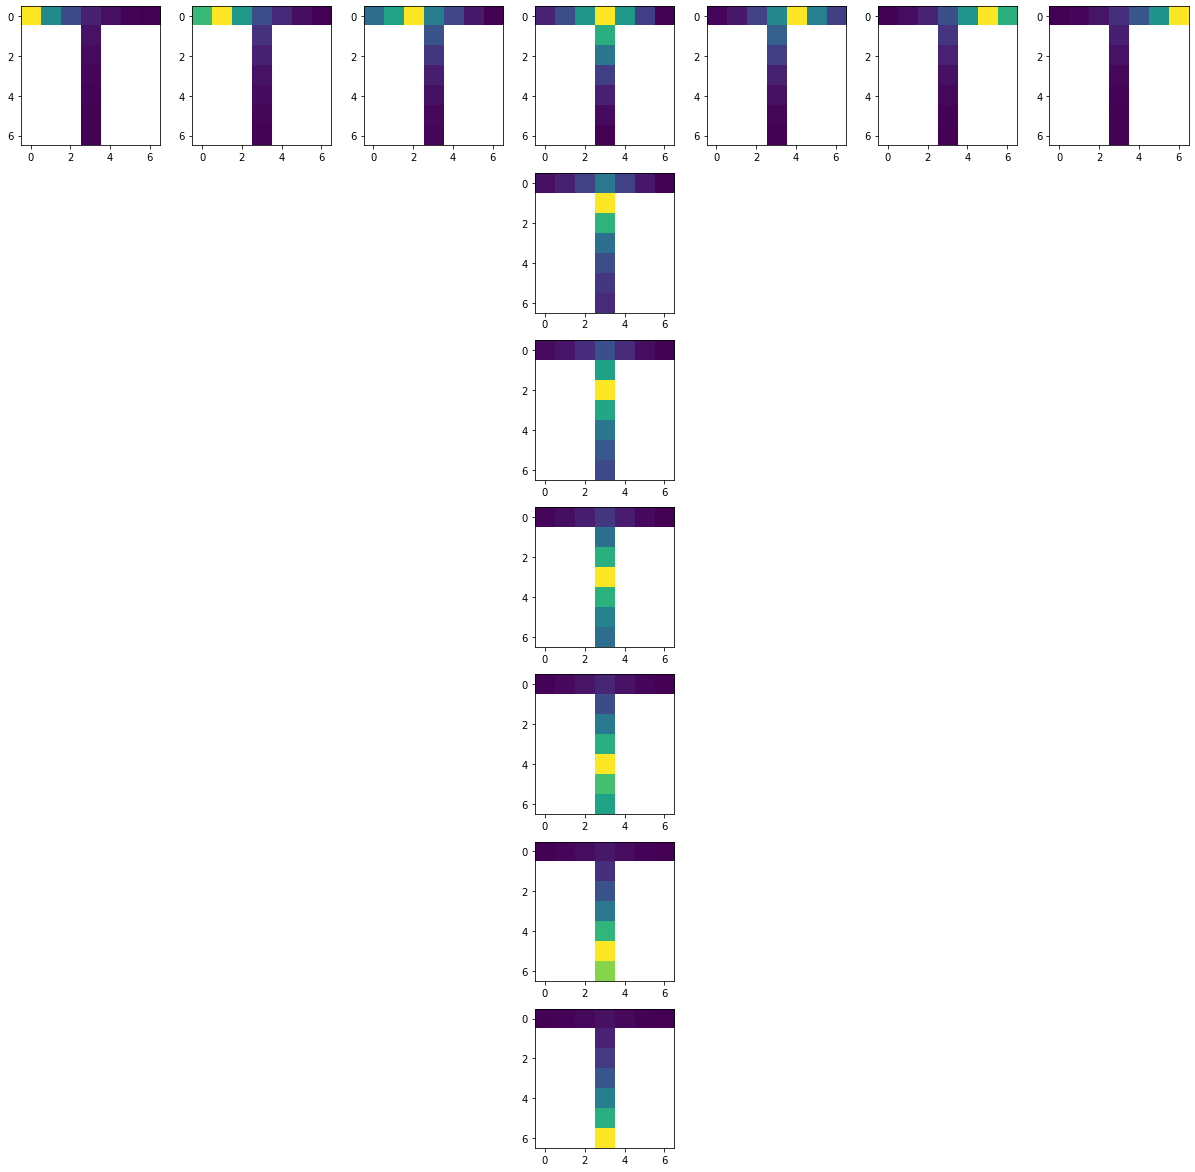

In [23]:
averaged_M = np.reshape(averaged_M, [env.state_size, grid_size, grid_size])

cmap = plt.cm.viridis
cmap.set_bad(color='white')

plt.figure(1, figsize=(grid_size*3, grid_size*3))
for i in range(env.state_size):
    if env.state_to_point(i) not in env.blocks:
        ax = plt.subplot(grid_size, grid_size, i + 1)
        ax.imshow(utils.mask_grid(averaged_M[i,:,:], env.blocks), cmap=cmap)